In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from multiprocessing import process
import torch.optim as optim
import openslide as ops
from PIL import Image
import sys
import cv2
import random
import time
from pprint import pprint
import albumentations as A

C:\Users\scott\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### HookNet

In [3]:
# function to perform center crop for concatenating skip connections and the hook connection
def center_crop(x, size):
    transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(size=size)])
    return transform(x)

# define the conv-batchnorm-relu-conv-batchnorm-relu block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv(x)

# define the HookeNet model
class HookNet(nn.Module):
    def __init__(self, in_channels, out_channels, hook_crop) -> None:
        
        super(HookNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2)
        self.preskips_context = nn.ModuleList()
        self.preskips_target = nn.ModuleList()
        self.hook_crop = hook_crop
        
        # channel sizes for DoubleConv blocks
        features=[32, 64, 128, 256]
        
        # encoder
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # bottleneck
        self.bottleneck = DoubleConv(256, 320)
        
        # decoder
        for feature in reversed(features):
            self.decoder.append(DoubleConv(feature*2, feature))
        
        self.preskips_context.append(nn.Conv2d(320, 256, 3))
        self.preskips_context.append(nn.Conv2d(256, 128, 3))
        self.preskips_context.append(nn.Conv2d(128, 64, 3))
        self.preskips_context.append(nn.Conv2d(64, 32, 3))
        
        self.preskips_target.append(nn.Conv2d(352, 256, 3))
        self.preskips_target.append(nn.Conv2d(256, 128, 3))
        self.preskips_target.append(nn.Conv2d(128, 64, 3))
        self.preskips_target.append(nn.Conv2d(64, 32, 3))
        
        # final conv
        self.finalconv = nn.Conv2d(32, out_channels, 1)
        
    def context_forward(self, x):
        
        # store skip connection inputs
        skip_connections = []
        
        # apply encoder DoubleConvs
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        # reverse the skip connections
        skip_connections.reverse()
        
        # apply bottleneck
        x = self.bottleneck(x)
        
        # apply decoder DoubleConvs
        for decode, preskipconv, skip in zip(self.decoder, self.preskips_context, skip_connections):
            x = self.upsample(x)
            x = preskipconv(x)
            x = F.relu(torch.cat((center_crop(skip, (x.shape[2], x.shape[2])), x), dim=1))
            x = decode(x)
        
        # hook out to target branch
        hook = center_crop(x, (self.hook_crop, self.hook_crop))
        
        # final conv
        x = self.finalconv(x)
        
        # return x and hool
        return (hook, x)
    
    def target_forward(self, hook, x):
        
        # store skip connection inputs
        skip_connections = []
        
        # apply encoder DoubleConvs
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        # reverse the skip connections
        skip_connections.reverse()
        
        # apply bottleneck
        x = self.bottleneck(x)
        
        # hook in from context branch
        x = torch.cat((hook, x), dim=1)
        
        # apply decoder DoubleConvs
        for decode, preskipconv, skip in zip(self.decoder, self.preskips_target, skip_connections):
            x = self.upsample(x)
            x = preskipconv(x)
            x = F.relu(torch.cat((center_crop(skip, (x.shape[2], x.shape[2])), x), dim=1))
            x = decode(x)
        
        # final conv
        x = self.finalconv(x)
        
        # return x
        return x
    
    def forward(self, context_input, target_input):
        
        # forward pass of context branch
        hook, context_output = self.context_forward(context_input)
        print(hook.shape)
        # forward pass of target branch
        target_output = self.target_forward(hook, target_input)
        # return the outputs
        return (context_output, target_output)

### Dataset Functions

In [4]:
def extract_image_layer(mask_obj,level):
    """
    Outputs an array consisting of entire image at chosen layer
    
    Inputs: 
    image: OpenSlide object for active image
    mask: Openslide object for active mask

    level: what res patch comes from
    """
    
    imagex, imagey = mask_obj.level_dimensions[level]
    print(imagex, ' ', imagey)

    image_rgba = np.array(mask_obj.read_region((0,0),level,(imagex,imagey)))
    image_rgb = cv2.cvtColor(image_rgba, cv2.COLOR_RGBA2RGB)

    return image_rgb

def get_valid_coord_list(image,n):
    """
    Outputs a list of coordinates that fall on the edge of the mask that should be useful center coord for training and testing
    
    Inputes:
        image: openslide image object
        n: how many sample coordinates you want
    """
    lev = 3
    img = extract_image_layer(image,lev)*255;

    img_canny = cv2.Canny(mask_test,20,40)

    imx,imy = image.level_dimensions[lev]
    coord_list = []
    for i in range(imy):
        for j in range(imx):
            if mask_canny[i,j] == 255:
                coord_list.append((i,j))
    output_list = random.sample(coord_list,n)
    return output_list

def extract_hooknet_patch(image,origin,tile_size,target_level,context_level):
    """
    Outputs a patch from target level and context level
    
    inputs: 
    image: Openslide multilevel image
    origin: center of image wrt lowest layer (highest resolution)
    tile_size: how large
    """
    target_downsample_factor = int(image.level_downsamples[target_level])
    context_downsample_factor = int(image.level_downsamples[context_level])
    imagex, imagey = image.level_dimensions[0]
    tilex, tiley = tile_size
    
    # print(imagex, ' ', imagey)
    # print(target_downsample_factor, ' ', context_downsample_factor)
    buffer_x = np.floor(tilex/2)
    buffer_y = np.floor(tiley/2)

    x_coord, y_coord = origin
    
    # print(x_coord,y_coord)

    # top left coord for target and context images
    x_target = int(x_coord - buffer_x*target_downsample_factor)
    x_context = int(x_coord - buffer_x*context_downsample_factor)

    y_target = int(y_coord - buffer_y*target_downsample_factor)
    y_context = int(y_coord - buffer_y*context_downsample_factor)

    target_rgba = np.array(image.read_region((x_target,y_target),target_level,(tilex,tiley)))
    target_rgb = cv2.cvtColor(target_rgba, cv2.COLOR_RGBA2RGB)

    context_rgba = np.array(image.read_region((x_context,y_context),context_level,(tilex,tiley)))
    context_rgb = cv2.cvtColor(context_rgba, cv2.COLOR_RGBA2RGB)
    return target_rgb, context_rgb


def extract_double_patch(image,mask,origin,size,level=1):
    """
    Simultaneously extracts a patch from an image and its corresponding mask at the given coordinates and size
    
    Inputs: 
    image: OpenSlide object for active image
    mask: Openslide object for active mask
    origin: center of image (x,y) wrt layer 0
    size: size of patch (x,y)
    level: what res patch comes from
    """
    
    downsample_factor = int(image.level_downsamples[level])
    
    imagex, imagey = image.level_dimensions[0]
    tilex, tiley = size
    # print(tilex, ' ', tiley)
    #Center of patch at layer 0
    x_coord, y_coord = origin
    # print(x_coord, ' ', y_coord)

    # top left coord for images
    x_target = int(x_coord - tilex/2*downsample_factor)
    y_target = int(y_coord - tiley/2*downsample_factor)
    print(x_target, ' ', y_target)

    image_rgba = np.array(image.read_region((x_target,y_target),level,(tilex,tiley)))
    image_rgb = cv2.cvtColor(image_rgba, cv2.COLOR_RGBA2RGB)
    
    mask_rgba = np.array(mask.read_region((x_target,y_target),level,(tilex,tiley)))
    mask_rgb = cv2.cvtColor(mask_rgba, cv2.COLOR_RGBA2RGB)

    return image_rgb, mask_rgb
    

def extract_patch(image,origin,size,level=1):
    """
    Extracts a single patch from chosen image at chosen layer
    
    Inputs: 
    image: OpenSlide object for active image
    mask: Openslide object for active mask
    origin: center of image (x,y) wrt layer 0
    size: size of patch (x,y)
    level: what res patch comes from
    """
    
    downsample_factor = int(image.level_downsamples[level])
    
    imagex, imagey = image.level_dimensions[0]
    tilex, tiley = size
    print(tilex, ' ', tiley)
    #Center of patch at layer 0
    x_coord, y_coord = origin
    print(x_coord, ' ', y_coord)

    # top left coord for images
    x_target = int(x_coord - tilex/2*downsample_factor)
    y_target = int(y_coord - tiley/2*downsample_factor)
    print(x_target, ' ', y_target)

    image_rgba = np.array(image.read_region((x_target,y_target),level,(tilex,tiley)))
    image_rgb = cv2.cvtColor(image_rgba, cv2.COLOR_RGBA2RGB)


    return image_rgb


In [15]:
# # batch iterator config
# user_config = '/home/krishna/Documents/mip_project/code/segmentation/user_config_seg.yml'
# # number of cpus used to extract patches on multiple cores
# cpus = 1
# # create iterators for the dataset
# training_iterator = create_batch_iterator(user_config=user_config, mode='training', cpus=cpus, buffer_dtype=np.uint8)
# test_iterator = create_batch_iterator(user_config=user_config, mode='inference', cpus=cpus, buffer_dtype=np.uint8)    

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


((33728, 26240), (16864, 13120), (8432, 6560), (4216, 3280), (2108, 1640), (1054, 820), (527, 410))
((33728, 26240), (16864, 13120), (8432, 6560), (4216, 3280), (2108, 1640), (1054, 820), (527, 410))
(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0)


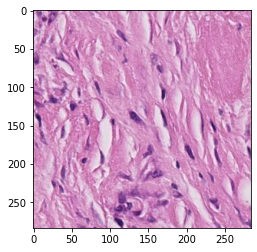

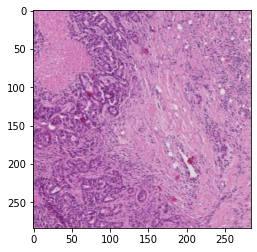

In [9]:
# Testing block - should display a single target/context image pair
mask_path = "D:/School/Spring2022/mip/Tiling/123S_mask.tif"
img_path = "D:/School/Spring2022/mip/Tiling/123S.tif"

image = ops.OpenSlide(img_path)
print(image.level_dimensions)
mask = ops.OpenSlide(mask_path)
print(mask.level_dimensions)
print(image.level_downsamples)
origin = (22435,11000)
size = (284,284)

image_test,mask_test = extract_hooknet_patch(image,origin,size,0,3)
plt.figure()
plt.imshow(image_test)
plt.figure()
plt.imshow(mask_test)

### Begin Code

In [43]:
# Dataset creation

# Example Inference Dataset Creation - iterating over grid of points

# Load in image (should be looped for implimentation)
mask_path = "D:/School/Spring2022/mip/Tiling/123S_mask.tif"
img_path = "D:/School/Spring2022/mip/Tiling/123S.tif"

# Create OpenSlide Objects
image = ops.OpenSlide(img_path)
mask = ops.OpenSlide(mask_path)

# Patch Size
size = (1244,1244)

# Hooknet context layer
context_layer = 3

# % overlap in the x and y direction
# overlap = (0.25,0.25)

# grid_spacing = (round(size[0]*(1-overlap[0])),round(size[1]*(1-overlap[1])))
grid_spacing = (1030,1030)

# Finding mask extents
mask_im = extract_image_layer(mask,6)
masky, maskx = mask.level_dimensions[6]
mask_df = mask.level_downsamples[6]
for x1 in range(maskx):
    layer = mask_im[x1,:]
    if 1 in layer:
        break
for y1 in range(masky):
    layer = mask_im[:,y1]
    if 1 in layer:
        break
for x2 in range(maskx-1, 0, -1):
    layer = mask_im[x2,:]
    if 1 in layer:
        break
for y2 in range(masky-1, 0, -1):
    layer = mask_im[:,y2]
    if 1 in layer:
        break
# Converting to layer 0 coordinates
x1 = round((x1+0.5)*mask_df)
x2 = round((x2+0.5)*mask_df)
y1 = round((y1+0.5)*mask_df)
y2 = round((y2+0.5)*mask_df)

x_coord_list = list(range(x1,x2,grid_spacing[0]))
if x2 not in x_coord_list:
    x_coord_list.append(x2) 
y_coord_list = list(range(y1,y2,grid_spacing[1]))
if y2 not in y_coord_list:
    y_coord_list.append(y2)

    
target_images = []
context_images = []
counter = 0

for j in y_coord_list:
    for i in x_coord_list:
        origin = (i,j)
        target,context = extract_hooknet_patch(image,origin,size,0,context_layer)
        target_images.append(target)
        context_images.append(context)

527   410


In [44]:
np.shape(context_images)

(285, 1244, 1244, 3)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#def hooknet parameters for training - 1030
net = HookNet(3, 7, 42)
net.load_state_dict(torch.load('D:/School/Spring2022/mip/Tiling/weights_180.pth',map_location=torch.device('cpu')))
net.to(device)
net.eval()

# Net for TIL detection
tilnet = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, num_classes=2, pretrained_backbone=False)
tilnet.load_state_dict(torch.load('D:/School/Spring2022/mip/Tiling/detection_final.pth',map_location=torch.device('cpu')))
tilnet.to(device)
tilnet.eval()

cpu


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [8]:
def dice_loss(output, target):

    eps = 0.0001

    intersection = output * target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + target
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [7]:
# # get input data and true masks
target_images = np.asarray(target_images)
context_images = np.asarray(context_images)
# y_batch_in = torch.from_numpy(y_batch).type(torch.FloatTensor).permute((0,1,4,2,3)).to(device)

# context_out, target_out = net(x_batch_in[:,1,:,:,:].squeeze(), x_batch_in[:,0,:,:,:].squeeze())

active_target = target_images[80][:][:][:]
active_target = np.expand_dims(active_target, axis=0)

active_context = context_images[80][:][:][:]
active_context = np.expand_dims(active_context, axis=0)

# # convert images to tensors
target_in = torch.from_numpy(active_target).type(torch.FloatTensor).permute((0,3,1,2)).to(device)/255
context_in = torch.from_numpy(active_context).type(torch.FloatTensor).permute((0,3,1,2)).to(device)/255

# context_out, target_out = net(target_in,context_in)


NameError: name 'target_images' is not defined

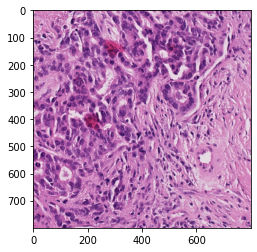

In [10]:
# plt.imshow(target_images[80][:][:][:])
origin = (22000,11000)
size = (800,800)

active_target,active_context = extract_hooknet_patch(image,origin,size,0,3)
active_target = np.expand_dims(active_target, axis=0)
active_context = np.expand_dims(active_context, axis=0)

# # convert images to tensors
target_in = torch.from_numpy(active_target).type(torch.FloatTensor).permute((0,3,1,2)).to(device)/255
context_in = torch.from_numpy(active_context).type(torch.FloatTensor).permute((0,3,1,2)).to(device)/255

plt.imshow(active_target[0])
# context_out, target_out = net(target_in,context_in)

torch.Size([1, 32, 42, 42])
torch.Size([1, 7, 582, 582])
tensor(137281.6406)
tensor(0.9689)
tensor(0.0041)


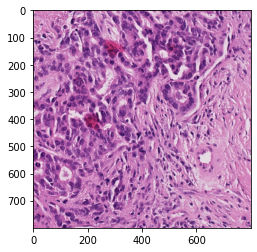

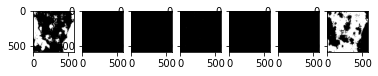

In [11]:
context_out, target_out = net(target_in,context_in)
context_out = context_out.detach().cpu()
target_out = target_out.detach().cpu()

target_out = torch.sigmoid(target_out)

print(target_out.shape)
print(torch.sum(target_out[0,0,:,:]))
print(torch.max(target_out[0,0,:,:]))
print(torch.min(target_out[0,0,:,:]))


context_out[context_out >= 0.5] = 1
context_out[context_out < 0.5] = 0
target_out[target_out >= 0.5] = 1
target_out[target_out < 0.5] = 0
# print(target_out)

context_out = context_out.numpy().astype(np.uint8)
target_out = target_out.numpy().astype(np.uint8)

plt.imshow(active_target[0,:,:,:])
plt.show()


fig, axes = plt.subplots(1, 7)
for i in range(7):
    axes[i].imshow(target_out[0,i,:,:], cmap='gray', vmax=1, vmin=0)
plt.show()


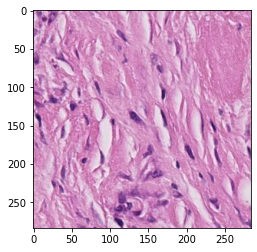

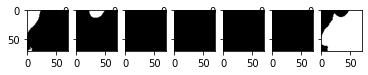

In [22]:
plt.imshow(active_target[0,:,:,:])
plt.show()


fig, axes = plt.subplots(1, 7)
for i in range(7):
    axes[i].imshow(target_out[0,i,:,:], cmap='gray', vmax=1, vmin=0)
plt.show()

# plt.figure
# plt.imshow(active_target[0,1,:,:])

In [62]:
test_out = tilnet(target_in[:,:,400:600,400:600])

In [63]:
test = test_out[0]["masks"]
test = test.detach().numpy()

# test_out[0]['boxes']

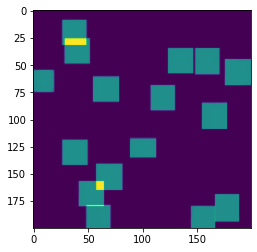

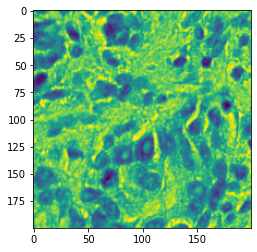

In [ ]:
n,c,x,y = np.shape(test)
test_full = np.zeros([x,y])
for i in range(n):
    test_full += test[i,0,:,:]
plt.figure()
plt.imshow(test_full)
plt.figure()
plt.imshow(target_in[0,0,400:600,400:600])

In [12]:
til_count = 0
active_image = target_in[:,:,109:691,109:691]
for i in tqdm(list([0, 194, 388])):
    for j in list([0, 194, 388]):
        test_out = tilnet(active_image[:,:,i:i+194,j:j+194])
        test = test_out[0]["masks"]
        test = test.detach().numpy()
        n,c,x,y = np.shape(test)
        test_full = np.zeros([x,y])
        for i in range(n):
            test_full += test[i,0,:,:]
        boring = np.multiply(target_out[0,0,i:i+194,j:j+194],test_full)
        til_count += np.count_nonzero(boring)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:02<00:00, 20.88s/it]


In [1]:
til_count/np.count_nonzero(target_out[0,0,:,:])

NameError: name 'til_count' is not defined